# Air Quality Prediction

Dataset: https://archive.ics.uci.edu/ml/datasets/Air+Quality

Attribute Information:
* 0 Date	(DD/MM/YYYY) 
* 1 Time	(HH.MM.SS) 
* 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
* 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
* 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
* 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
* 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
* 7 True hourly averaged NOx concentration in ppb (reference analyzer) 
* 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
* 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
* 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
* 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
* 12 Temperature in Â°C	
* 13 Relative Humidity (%) 
* 14 AH Absolute Humidity 

**Missing values are tagged with -200 value.**

## Import Libaray

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing
* Drop Datetime feature column (the order already contain time series information)
* Drop all-nan rows and columns
* Convert string type into float type
* Calculate how many -200(nan) exists in each column, and drop the column which contains too many missing data
* Missing Data Imputation: (1) Plot correlation matrix(after filter -200 value) (2) Use Linear Regression to imputate missing data with high correlation feature (3) If regression score is smaller than 0.8, use mean instead of regression result
* Since EPA Administrator uses CO, NO2, PM2.5, PM10, O3, SO2 as standard of Air Quality Index and use maximum of their conversion as the AQI value, CO and NO2 are selected as air quality definition which is max(AQI(CO),AQI(NO2))
* EPA Administrator evaluates the concentration of CO on 8 hourly average, so the values are assigned with 8 hourly average value
* Plot quartiles graph to see if there are many outliers in CO and NO2 data. CO and NO2 has 301 and 380 outliers, respectively. Since it only account for a few ratio, it is no need for removing. Also, when we see the exact value, they are in common range of AQI.
* The time series curve is also be plotted. The plot of change of CO is more clear than the plot of NO2. NO2's curve seems to be more dramatical.
* Convert the concentration of CO and NO2 into their AQI However, we can see that only few CO's index is larger than NO2's index. Therefore, after AQI column is built, NO2 column is removed because we don't need too highly similar columns to train the model.

In [2]:
def readTrain(filename, skipped):
    train = pd.read_csv(filename, sep=';',usecols=lambda x: x not in skipped)
    return train

In [3]:
columns_to_skip = ['Date','Time']
df = readTrain('air_data.csv', columns_to_skip)

In [4]:
df = df.dropna(how='all')
df = df.dropna(axis='columns')

In [5]:
for c in df.columns:
    print(type(df[c][0]))

<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>
<class 'str'>


In [6]:
for c in df.columns:
    if c!='Date' and c!='Time' and isinstance(df[c][0], str):
        df[c] = df[c].apply(lambda x: float(x.replace(',','.')))

In [7]:
idx = []
nan_row = {'CO(GT)':0,'PT08.S1(CO)':0,'NMHC(GT)':0,'C6H6(GT)':0,'PT08.S2(NMHC)':0,'NOx(GT)':0,'PT08.S3(NOx)':0,'NO2(GT)':0,'PT08.S4(NO2)':0,'PT08.S5(O3)':0,'T':0,'RH':0,'AH':0}
for index, row in df.iterrows():
    for c in nan_row.keys():
        if row[c]==-200:
            nan_row[c]+=1
            idx.append(index)

In [8]:
nan_row

{'CO(GT)': 1683,
 'PT08.S1(CO)': 366,
 'NMHC(GT)': 8443,
 'C6H6(GT)': 366,
 'PT08.S2(NMHC)': 366,
 'NOx(GT)': 1639,
 'PT08.S3(NOx)': 366,
 'NO2(GT)': 1642,
 'PT08.S4(NO2)': 366,
 'PT08.S5(O3)': 366,
 'T': 366,
 'RH': 366,
 'AH': 366}

In [9]:
df = df.drop(columns=['NMHC(GT)'])
df_ = df.drop(list(set(idx)))

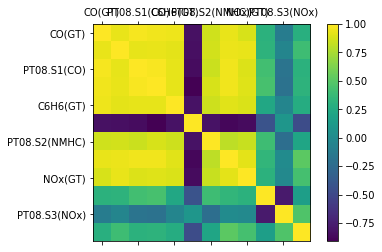

In [10]:
import matplotlib.pyplot as plt

alpha = list(df_.columns)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [11]:
tmp = df_.corr().abs()

In [12]:
for c in df_.columns:
    print(tmp[c].sort_values())

RH               0.105157
AH               0.295591
T                0.318261
PT08.S3(NOx)     0.823728
NO2(GT)          0.861432
PT08.S5(O3)      0.882943
PT08.S1(CO)      0.936261
PT08.S4(NO2)     0.939921
NOx(GT)          0.951342
PT08.S2(NMHC)    0.958426
C6H6(GT)         0.972660
CO(GT)           1.000000
Name: CO(GT), dtype: float64
RH               0.039570
T                0.324815
AH               0.407038
PT08.S3(NOx)     0.829577
NO2(GT)          0.866579
NOx(GT)          0.922885
C6H6(GT)         0.931368
PT08.S5(O3)      0.935011
CO(GT)           0.936261
PT08.S2(NMHC)    0.936346
PT08.S4(NO2)     0.945020
PT08.S1(CO)      1.000000
Name: PT08.S1(CO), dtype: float64
RH               0.178410
AH               0.313415
T                0.418409
NO2(GT)          0.846743
PT08.S3(NOx)     0.848850
PT08.S5(O3)      0.896978
NOx(GT)          0.927304
PT08.S1(CO)      0.931368
PT08.S4(NO2)     0.960811
CO(GT)           0.972660
PT08.S2(NMHC)    0.984834
C6H6(GT)         1.000000
N

In [13]:
# find highest correlation feature for each
pair=[['CO(GT)','C6H6(GT)'],\
     ['PT08.S1(CO)','PT08.S4(NO2)'],\
     ['C6H6(GT)','PT08.S2(NMHC)'],\
     ['PT08.S2(NMHC)','C6H6(GT)'],\
     ['NOx(GT)','CO(GT)'],\
     ['PT08.S3(NOx)','PT08.S2(NMHC)'],\
     ['NO2(GT)','PT08.S2(NMHC)'],\
     ['PT08.S4(NO2)','C6H6(GT)'],\
     ['PT08.S5(O3)','PT08.S1(CO)']]

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
miss = dict.fromkeys(df.columns)
score = dict.fromkeys(df.columns)
for p in pair:
    print(p)
    df_tmp = pd.DataFrame(df, columns=p)
    df_tmp = df_tmp.loc[df_tmp[p[0]]!=-200]
    df_tmp = df_tmp.loc[df_tmp[p[1]]!=-200]
    
    X = np.array(list(df_tmp[p[1]])).reshape(-1, 1)
    y = np.array(list(df_tmp[p[0]])).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    score[p[0]] = reg.score(X,y)
    print(reg.score(X,y))
    
    df_tmp = pd.DataFrame(df, columns=p)
    df_tmp = df_tmp.loc[df_tmp[p[0]] ==-200]
    miss[p[0]] = reg.predict(np.array(list(df_tmp[p[1]])).reshape(-1, 1))

['CO(GT)', 'C6H6(GT)']
0.8669068473182029
['PT08.S1(CO)', 'PT08.S4(NO2)']
0.46632679816621436
['C6H6(GT)', 'PT08.S2(NMHC)']
0.9642264227022088
['PT08.S2(NMHC)', 'C6H6(GT)']
0.9642264227022088
['NOx(GT)', 'CO(GT)']
0.6320702354277932
['PT08.S3(NOx)', 'PT08.S2(NMHC)']
0.6347362813041744
['NO2(GT)', 'PT08.S2(NMHC)']
0.4176329650224425
['PT08.S4(NO2)', 'C6H6(GT)']
0.5863445130410294
['PT08.S5(O3)', 'PT08.S1(CO)']
0.8087827962217311


In [15]:
# if reg score is higher than 0.8, assign the values
for c in df.columns:
    if score[c] and score[c]>=0.8:
        x = 0
        for i in range(len(df)):
            if df[c][i]==-200:
                df.loc[i,p[0]] = miss[c][x]
                x+=1

In [16]:
# if reg score is smaller than 0.8, assign the mean of the feature
for c in df.columns:
    count = 0
    for x in list(df[c]):
        if x==-200:
            count+=1
    fake_mean = np.mean(df[c])
    true_mean = (fake_mean*len(df)-(-200)*count)/(len(df)-nan_row[c])
    df[c] = df[c].apply(lambda x: true_mean if x == -200 else x)

## Take CO and NO2 as targets

In [17]:
# reassign CO's value with 8 hourly average value
for i in range(len(df)):
    if i<8:
        df.loc[i,'CO(GT)'] = np.mean(df['CO(GT)'][:i+1])
    else:
        df.loc[i,'CO(GT)'] = np.mean(df['CO(GT)'][i-8:i+1])

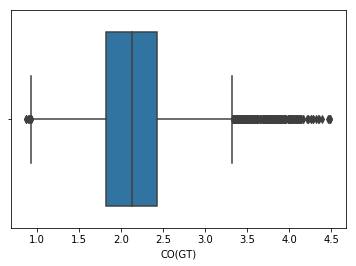

In [18]:
import seaborn as sns
sns.boxplot(x=df['CO(GT)'])

In [19]:
co = sorted(list(df['CO(GT)']))
Q1 = (co[int(0.25*len(co))]+co[int(0.25*len(co))+1])/2
Q3 = (co[int(0.75*len(co))]+co[int(0.75*len(co))+1])/2
outlier_top = Q3+(Q3-Q1)*1.5
outlier_buttom = Q1-(Q3-Q1)*1.5

In [20]:
print(outlier_buttom, outlier_top)

0.9242777055787319 3.323680323992303


In [21]:
#print number of outlier
sum(1 for i in co if i > outlier_top)+sum(1 for i in co if i < outlier_buttom)

301

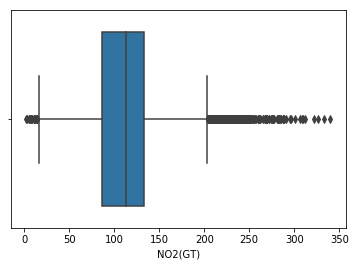

In [22]:
import seaborn as sns
sns.boxplot(x=df['NO2(GT)'])

In [23]:
no2 = sorted(list(df['NO2(GT)']))
Q1 = (no2[int(0.25*len(no2))]+no2[int(0.25*len(no2))+1])/2
Q3 = (no2[int(0.75*len(no2))]+no2[int(0.75*len(no2))+1])/2
outlier_buttom = Q1-(Q3-Q1)*1.5
outlier_top = Q3+(Q3-Q1)*1.5

In [24]:
print(outlier_buttom, outlier_top)

15.5 203.5


In [25]:
sum(1 for i in no2 if i > outlier_top)+sum(1 for i in no2 if i < outlier_buttom)

380

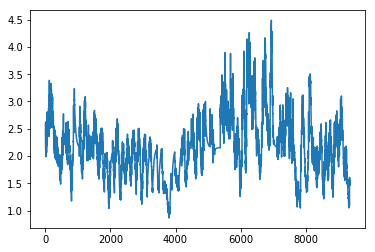

In [26]:
plt.plot(range(len(df)),df['CO(GT)'])

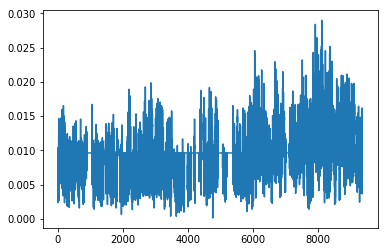

In [27]:
from sklearn.preprocessing import normalize
plt.plot(range(len(df)),normalize(np.array(df['NO2(GT)']).reshape(-1,1),axis=0).ravel())

### The standard AQI of EPA Administrator 
|AQI|CO|NO2|
|---|---|---|
|0～50|0 - 4.4|0 - 53|
|51～100|4.5 - 9.4|54 - 100|
|101～150|9.5 - 12.4|101 - 360|
|151～200|12.5 - 15.4|361 - 649|
|201～300|15.5 - 30.4|650 - 1249|
|301～400|30.5 - 40.4|1250 - 1649|
|401～500|40.5 - 50.4|1650 - 2049|

## Convert the value to AQI

In [28]:
MAP = {'AQI':[0,51,101,151,201,301,401,501],
       'CO':[0,4.5,9.5,12.5,15.5,30.5,40.5,50.5],
       'NO2':[0,54,101,361,650,1250,1650,2050]
    }

In [29]:
slope_intercept = {'CO':[],'NO2':[]}
for i in range(1,len(MAP['AQI'])):
    cx1 = MAP['CO'][i-1]
    nx1 = MAP['NO2'][i-1]
    y1 = MAP['AQI'][i-1]
    cx2 = MAP['CO'][i]-0.1
    nx2 = MAP['NO2'][i]-1
    y2 = MAP['AQI'][i]-1
    ca = (y2-y1)/(cx2-cx1)
    cb = y1-ca*cx1
    na = (y2-y1)/(nx2-nx1)
    nb = y1-na*nx1
    slope_intercept['CO'].append((ca,cb))
    slope_intercept['NO2'].append((na,nb))
    

In [30]:
slope_intercept

{'CO': [(11.363636363636363, 0.0),
  (10.0, 6.0),
  (16.89655172413793, -59.51724137931032),
  (16.89655172413793, -60.2068965517241),
  (6.644295302013424, 98.01342281879194),
  (10.000000000000002, -4.000000000000057),
  (10.000000000000002, -4.000000000000057)],
 'NO2': [(0.9433962264150944, 0.0),
  (1.065217391304348, -6.5217391304347885),
  (0.1891891891891892, 81.89189189189189),
  (0.1701388888888889, 89.57986111111111),
  (0.1652754590984975, 93.57095158597663),
  (0.24812030075187969, -9.150375939849596),
  (0.24812030075187969, -8.398496240601503)]}

In [31]:
def return_interval(s, f):
    for i in range(1,len(MAP[s])):
        if f<MAP[s][i]:
            return i-1

In [32]:
co = list(df['CO(GT)'])
no2 = list(df['NO2(GT)'])
aqi = []
caqi = []
naqi = []
count = 0
for i in range(len(co)):
    ca, cb = slope_intercept['CO'][return_interval('CO',co[i])]
    na, nb = slope_intercept['NO2'][return_interval('NO2',no2[i])]
    c = ca*co[i]+cb
    n = na*no2[i]+nb
    caqi.append(c)
    naqi.append(n)
    MAX = max(c,n)
    aqi.append(MAX)

In [33]:
sum(1 for i in range(len(aqi)) if aqi[i]!=naqi[i])

45

In [34]:
df.insert(len(df.columns), "AQI", aqi, True)

In [35]:
df = df.drop(columns=['NO2(GT)'])

In [36]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,AQI
0,2.600000,1360.0,11.9,1046.0,166.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,103.270270
1,2.300000,1292.0,9.4,955.0,103.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,91.478261
2,2.366667,1402.0,9.0,939.0,131.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,103.459459
3,2.366667,1376.0,9.2,948.0,172.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,104.972973
4,2.246667,1272.0,6.5,836.0,131.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,103.837838


In [37]:
df.to_csv('data.csv', sep=';')

# Training model
* Given previous 5-day data(input), we would like to predict AQI of the next 5 days(output)
* Use RNN(with LSTM) model to learn the time series pattern and predict the AQI

In [56]:
def buildTrain(train, pastHour=120, futureHour=120):
    XX, yy = [], []
    from sklearn.preprocessing import normalize
    from sklearn.utils import shuffle
    for i in range(train.shape[0]-futureHour-pastHour):
        x = np.array(train.iloc[i:i+pastHour])
        x = normalize(x, axis=1)
        XX.append(x)
        yy.append(np.array(train.iloc[i+pastHour:i+pastHour+futureHour]["AQI"]))
    XX, yy = shuffle(XX, yy)
    return np.array(XX[:int(len(XX)*0.7)]), np.array(yy[:int(len(yy)*0.7)]), np.array(XX[int(len(XX)*0.7):]), np.array(yy[int(len(yy)*0.7):])

In [57]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [58]:
def buildManyToManyModel(shape):
    model = Sequential()
    model.add(LSTM(13, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Lambda(lambda x: x[:, -5*24:, :]))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [59]:
from keras.layers import Lambda
from sklearn.model_selection import ShuffleSplit

In [60]:
df = readTrain('data.csv', [])
X_train, y_train, X_test, y_test = buildTrain(df, 5*24, 5*24)
splits = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [61]:
for train_idx, val_idx in splits.split(X_train):
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv = y_train[val_idx]
    y_train_cv = y_train_cv[:,:,np.newaxis]
    y_valid_cv = y_valid_cv[:,:,np.newaxis]
    model = buildManyToManyModel(X_train_cv.shape)
    callback = EarlyStopping(monitor="val_loss", min_delta=0.1, patience=10, verbose=10, mode="auto")
    history = model.fit(X_train_cv, y_train_cv, epochs=500, batch_size=128, validation_data=(X_valid_cv, y_valid_cv), callbacks=[callback])

/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(13, return_sequences=True, input_shape=(120, 13))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 13)           1404      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 120, 1)            14        
_________________________________________________________________
lambda_2 (Lambda)            (None, 120, 1)            0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Train on 4466 samples, validate on 1915 samples
Epoch 1/500
4466/4466 [==============================] - 7s 2ms/step - loss: 9229.8265 - val_loss: 9134.4516
Epoch 2/500
4466/4466 [==============================] - 6s 1ms/step - loss: 9004.6951 - val_loss: 8851.2108
Epoch 3/500
4466/4466 [==============================] - 7s 2ms/step - loss: 8715.3694 - val_loss: 8554.9755
Epoch 4/500
4466/4466 [======

4466/4466 [==============================] - 6s 1ms/step - loss: 1408.7804 - val_loss: 1395.1872
Epoch 143/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1388.2104 - val_loss: 1374.6785
Epoch 144/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1367.8884 - val_loss: 1354.6314
Epoch 145/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1347.9457 - val_loss: 1334.7927
Epoch 146/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1328.2523 - val_loss: 1315.3765
Epoch 147/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1308.9461 - val_loss: 1296.1155
Epoch 148/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1289.8910 - val_loss: 1277.2100
Epoch 149/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1271.1269 - val_loss: 1258.7025
Epoch 150/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1252.7220 - val_loss: 1240.4005
Epoch 151/500
4

Epoch 217/500
4466/4466 [==============================] - 7s 1ms/step - loss: 596.2638 - val_loss: 591.7032
Epoch 218/500
4466/4466 [==============================] - 6s 1ms/step - loss: 593.1044 - val_loss: 588.6751
Epoch 219/500
4466/4466 [==============================] - 6s 1ms/step - loss: 590.1186 - val_loss: 585.6681
Epoch 220/500
4466/4466 [==============================] - 7s 1ms/step - loss: 587.2030 - val_loss: 582.8827
Epoch 221/500
4466/4466 [==============================] - 7s 1ms/step - loss: 584.4533 - val_loss: 580.1545
Epoch 222/500
4466/4466 [==============================] - 6s 1ms/step - loss: 581.7976 - val_loss: 577.5833
Epoch 223/500
4466/4466 [==============================] - 7s 1ms/step - loss: 579.2745 - val_loss: 575.1052
Epoch 224/500
4466/4466 [==============================] - 7s 1ms/step - loss: 576.8556 - val_loss: 572.7366
Epoch 225/500
4466/4466 [==============================] - 7s 1ms/step - loss: 574.5490 - val_loss: 570.4755
Epoch 226/500
4466/

/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(13, return_sequences=True, input_shape=(120, 13))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 120, 13)           1404      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 120, 1)            14        
_________________________________________________________________
lambda_3 (Lambda)            (None, 120, 1)            0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Train on 4466 samples, validate on 1915 samples
Epoch 1/500
4466/4466 [==============================] - 7s 2ms/step - loss: 9229.9782 - val_loss: 9076.9680
Epoch 2/500
4466/4466 [==============================] - 7s 2ms/step - loss: 8964.1649 - val_loss: 8752.9377
Epoch 3/500
4466/4466 [==============================] - 7s 1ms/step - loss: 8666.8146 - val_loss: 8477.3908
Epoch 4/500
4466/4466 [======

4466/4466 [==============================] - 6s 1ms/step - loss: 1381.7364 - val_loss: 1361.3563
Epoch 143/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1361.5173 - val_loss: 1341.4567
Epoch 144/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1341.5871 - val_loss: 1321.9130
Epoch 145/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1321.9848 - val_loss: 1302.6525
Epoch 146/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1302.6882 - val_loss: 1283.6939
Epoch 147/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1283.6847 - val_loss: 1265.0780
Epoch 148/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1265.0111 - val_loss: 1246.7192
Epoch 149/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1246.6280 - val_loss: 1228.6660
Epoch 150/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1228.5588 - val_loss: 1210.8755
Epoch 151/500
4

Epoch 217/500
4466/4466 [==============================] - 7s 1ms/step - loss: 589.9174 - val_loss: 590.1416
Epoch 218/500
4466/4466 [==============================] - 7s 1ms/step - loss: 586.9060 - val_loss: 587.3611
Epoch 219/500
4466/4466 [==============================] - 6s 1ms/step - loss: 584.0501 - val_loss: 584.6779
Epoch 220/500
4466/4466 [==============================] - 6s 1ms/step - loss: 581.3150 - val_loss: 582.0890
Epoch 221/500
4466/4466 [==============================] - 6s 1ms/step - loss: 578.6848 - val_loss: 579.6400
Epoch 222/500
4466/4466 [==============================] - 7s 1ms/step - loss: 576.1897 - val_loss: 577.2656
Epoch 223/500
4466/4466 [==============================] - 6s 1ms/step - loss: 573.7728 - val_loss: 575.0713
Epoch 224/500
4466/4466 [==============================] - 6s 1ms/step - loss: 571.5034 - val_loss: 572.9279
Epoch 225/500
4466/4466 [==============================] - 6s 1ms/step - loss: 569.3219 - val_loss: 570.8950
Epoch 226/500
4466/

/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(13, return_sequences=True, input_shape=(120, 13))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 120, 13)           1404      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 120, 1)            14        
_________________________________________________________________
lambda_4 (Lambda)            (None, 120, 1)            0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Train on 4466 samples, validate on 1915 samples
Epoch 1/500
4466/4466 [==============================] - 7s 2ms/step - loss: 9301.0931 - val_loss: 9228.0435
Epoch 2/500
4466/4466 [==============================] - 7s 1ms/step - loss: 9046.0893 - val_loss: 8878.6831
Epoch 3/500
4466/4466 [==============================] - 6s 1ms/step - loss: 8739.9598 - val_loss: 8597.4508
Epoch 4/500
4466/4466 [======

4466/4466 [==============================] - 6s 1ms/step - loss: 1396.1642 - val_loss: 1383.4337
Epoch 143/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1375.7932 - val_loss: 1363.1204
Epoch 144/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1355.6745 - val_loss: 1343.2349
Epoch 145/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1335.9529 - val_loss: 1323.4837
Epoch 146/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1316.4500 - val_loss: 1304.1842
Epoch 147/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1297.3366 - val_loss: 1285.0625
Epoch 148/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1278.4646 - val_loss: 1266.3424
Epoch 149/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1259.9257 - val_loss: 1247.9281
Epoch 150/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1241.6917 - val_loss: 1229.8131
Epoch 151/500
4

Epoch 217/500
4466/4466 [==============================] - 6s 1ms/step - loss: 595.2025 - val_loss: 588.2435
Epoch 218/500
4466/4466 [==============================] - 6s 1ms/step - loss: 592.1410 - val_loss: 585.2304
Epoch 219/500
4466/4466 [==============================] - 7s 1ms/step - loss: 589.2055 - val_loss: 582.3651
Epoch 220/500
4466/4466 [==============================] - 7s 1ms/step - loss: 586.4119 - val_loss: 579.5652
Epoch 221/500
4466/4466 [==============================] - 7s 1ms/step - loss: 583.7179 - val_loss: 576.9143
Epoch 222/500
4466/4466 [==============================] - 6s 1ms/step - loss: 581.1498 - val_loss: 574.3749
Epoch 223/500
4466/4466 [==============================] - 7s 1ms/step - loss: 578.6959 - val_loss: 571.9499
Epoch 224/500
4466/4466 [==============================] - 7s 1ms/step - loss: 576.3563 - val_loss: 569.6286
Epoch 225/500
4466/4466 [==============================] - 6s 1ms/step - loss: 574.1145 - val_loss: 567.4394
Epoch 226/500
4466/

/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(13, return_sequences=True, input_shape=(120, 13))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 120, 13)           1404      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 120, 1)            14        
_________________________________________________________________
lambda_5 (Lambda)            (None, 120, 1)            0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Train on 4466 samples, validate on 1915 samples
Epoch 1/500
4466/4466 [==============================] - 7s 2ms/step - loss: 9182.7048 - val_loss: 9032.7123
Epoch 2/500
4466/4466 [==============================] - 7s 1ms/step - loss: 8823.0292 - val_loss: 8621.7478
Epoch 3/500
4466/4466 [==============================] - 7s 1ms/step - loss: 8472.4530 - val_loss: 8308.4076
Epoch 4/500
4466/4466 [======

4466/4466 [==============================] - 6s 1ms/step - loss: 1349.8465 - val_loss: 1340.0860
Epoch 143/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1330.1087 - val_loss: 1320.5831
Epoch 144/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1310.6988 - val_loss: 1301.3398
Epoch 145/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1291.5954 - val_loss: 1282.3689
Epoch 146/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1272.7747 - val_loss: 1263.7430
Epoch 147/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1254.2554 - val_loss: 1245.4762
Epoch 148/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1236.0872 - val_loss: 1227.3966
Epoch 149/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1218.1648 - val_loss: 1209.7049
Epoch 150/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1200.5922 - val_loss: 1192.2378
Epoch 151/500
4

Epoch 217/500
4466/4466 [==============================] - 7s 1ms/step - loss: 586.0044 - val_loss: 586.6125
Epoch 218/500
4466/4466 [==============================] - 7s 1ms/step - loss: 583.2201 - val_loss: 583.9161
Epoch 219/500
4466/4466 [==============================] - 7s 1ms/step - loss: 580.5586 - val_loss: 581.3251
Epoch 220/500
4466/4466 [==============================] - 7s 2ms/step - loss: 578.0089 - val_loss: 578.8504
Epoch 221/500
4466/4466 [==============================] - 6s 1ms/step - loss: 575.5782 - val_loss: 576.4753
Epoch 222/500
4466/4466 [==============================] - 7s 1ms/step - loss: 573.2496 - val_loss: 574.2268
Epoch 223/500
4466/4466 [==============================] - 7s 1ms/step - loss: 571.0303 - val_loss: 572.0909
Epoch 224/500
4466/4466 [==============================] - 6s 1ms/step - loss: 568.9205 - val_loss: 570.0442
Epoch 225/500
4466/4466 [==============================] - 7s 1ms/step - loss: 566.9119 - val_loss: 568.0926
Epoch 226/500
4466/

/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cynthia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(13, return_sequences=True, input_shape=(120, 13))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 120, 13)           1404      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 120, 1)            14        
_________________________________________________________________
lambda_6 (Lambda)            (None, 120, 1)            0         
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Train on 4466 samples, validate on 1915 samples
Epoch 1/500
4466/4466 [==============================] - 8s 2ms/step - loss: 9269.6459 - val_loss: 9244.2893
Epoch 2/500
4466/4466 [==============================] - 7s 1ms/step - loss: 9007.1960 - val_loss: 8924.5081
Epoch 3/500
4466/4466 [==============================] - 6s 1ms/step - loss: 8699.9439 - val_loss: 8614.9184
Epoch 4/500
4466/4466 [======

4466/4466 [==============================] - 7s 2ms/step - loss: 1409.5517 - val_loss: 1418.9408
Epoch 143/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1388.9251 - val_loss: 1398.2428
Epoch 144/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1368.6674 - val_loss: 1377.7802
Epoch 145/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1348.7009 - val_loss: 1357.6323
Epoch 146/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1329.0272 - val_loss: 1337.8573
Epoch 147/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1309.7018 - val_loss: 1318.3231
Epoch 148/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1290.6326 - val_loss: 1299.1991
Epoch 149/500
4466/4466 [==============================] - 7s 1ms/step - loss: 1271.9344 - val_loss: 1280.2512
Epoch 150/500
4466/4466 [==============================] - 6s 1ms/step - loss: 1253.4848 - val_loss: 1261.6742
Epoch 151/500
4

Epoch 217/500
4466/4466 [==============================] - 6s 1ms/step - loss: 597.3749 - val_loss: 595.8384
Epoch 218/500
4466/4466 [==============================] - 7s 1ms/step - loss: 594.2422 - val_loss: 592.5542
Epoch 219/500
4466/4466 [==============================] - 6s 1ms/step - loss: 591.2190 - val_loss: 589.4398
Epoch 220/500
4466/4466 [==============================] - 7s 1ms/step - loss: 588.3391 - val_loss: 586.4243
Epoch 221/500
4466/4466 [==============================] - 7s 1ms/step - loss: 585.5679 - val_loss: 583.5678
Epoch 222/500
4466/4466 [==============================] - 7s 1ms/step - loss: 582.9356 - val_loss: 580.7865
Epoch 223/500
4466/4466 [==============================] - 7s 1ms/step - loss: 580.3941 - val_loss: 578.1670
Epoch 224/500
4466/4466 [==============================] - 6s 1ms/step - loss: 577.9918 - val_loss: 575.6097
Epoch 225/500
4466/4466 [==============================] - 7s 1ms/step - loss: 575.6826 - val_loss: 573.1716
Epoch 226/500
4466/

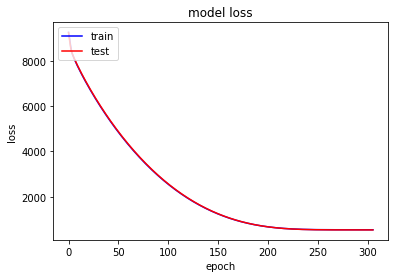

In [87]:
import matplotlib.pyplot as plt
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
predictions = model.predict(X_test)

In [137]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [138]:
mean_squared_error(y_test,predictions[:,:,0])

543.9387292990373

In [139]:
r2_score(y_test,predictions[:,:,0])

-0.007518498144947196

In [140]:
explained_variance_score(y_test,predictions[:,:,0])

-7.342700505384251e-06

# Discussion
* From the metrics, we can see the result is not very good. There may be some reasons: (1) Features are not enough to predict the AQI (2) Predict the next 5 day AQI from previous 5 days may not be best way since the period is too long for my model to learn more information 
* Despite capability of predict accurately, my model is trained properly since the training, validation, and test loss are very close.